# <b> Лабораторная работа №3 </b>

<b> Цель работы: </b>

Научиться создавать простые системы классификации изображений на основе сверточных нейронных сетей.


<b> Задание: </b>
1. Выбрать цель для задачи классификации и датасет (train/val: собрать либо найти, например, на Kaggle, test: собрать, разметить, не менее 50 изображений).
2. Зафиксировать архитектуру сети, loss, метрики качества.
3. Натренировать (либо дотренировать сеть) на выбранном датасете
4. Оценить качество работы по выбранной метрике на валидационной выборке, определить, не переобучилась ли модель.
5. Сделать отчёт в виде readme на GitHub, там же должен быть выложен исходный код.

In [1]:
# Стандартные библиотеки
import os
import shutil
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import random

# Библиотека для разделения данных
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Conv2D,MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score

## Загрузка датасета (Cats vs Dogs)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def unzip_file(zip_path, extract_to=None, delete_zip=False):
    '''
    Распаковка ZIP-архива
    '''

    # Если папка для распаковки не указана, создаем рядом
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]

    # Создаем папку, если ее нет
    os.makedirs(extract_to, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Получаем информацию о файлах
            file_list = zip_ref.namelist()
            print(f"Найдено {len(file_list)} файлов в архиве")

            # Распаковываем все файлы
            zip_ref.extractall(extract_to)


    except zipfile.BadZipFile:
        print(f"Ошибка: {zip_path} не является корректным ZIP-архивом")
        return False
    except Exception as e:
        print(f"Ошибка при распаковке: {e}")
        return False

    # Удаляем архив, если нужно
    if delete_zip:
        os.remove(zip_path)
        print(f"Архив удален: {zip_path}")

    return True

# Распаковка архива
unzip_file('/content/drive/MyDrive/dataset/dataset.zip', 'dataset')

Найдено 25046 файлов в архиве


True

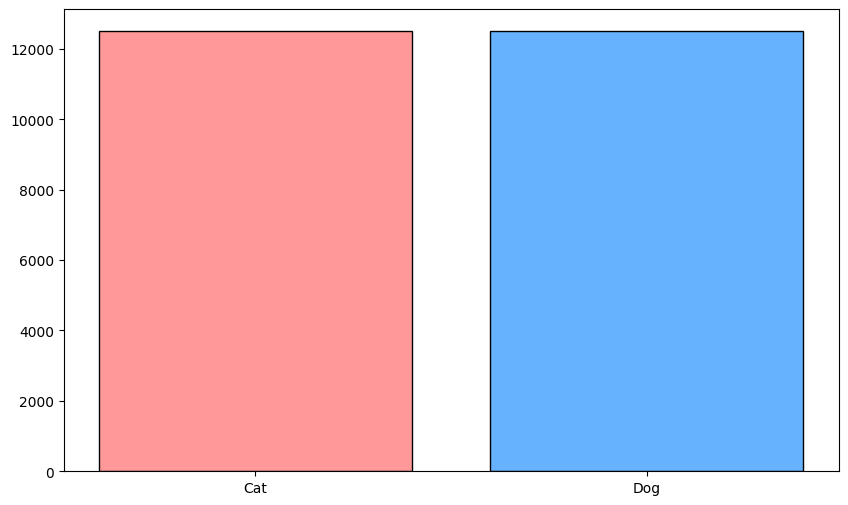

In [611]:
class_names = ['Cat', 'Dog']

n_dogs = len(os.listdir('dataset/Dog'))
n_cats = len(os.listdir('dataset/Cat'))
n_images = [n_cats, n_dogs]

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, n_images, color=['#FF9999', '#66B2FF'], edgecolor='black')

### Разделение датасета на тестовую и валидационную выборки

In [613]:
# Создаем структуру директорий
for split in ['train', 'val']:
    os.makedirs(f'dataset/{split}/Cat', exist_ok=True)
    os.makedirs(f'dataset/{split}/Dog', exist_ok=True)

In [614]:
def split_dataset(source_dir, target_class,
                  train_ratio = 0.8, val_ratio = 0.2,
                  random_state = 11):
    '''
    Разделение датасета на тестовую и валидационную выборки
    с использованием train_test_split
    '''
    # Получаем все изображения
    image_files = [f for f in os.listdir(source_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Разделение
    train_files, val_files = train_test_split(image_files,
                                              test_size    = val_ratio/(train_ratio + val_ratio),
                                              random_state = random_state,
                                              shuffle = True
                                             )

    # Копируем файлы
    def copy_files(files, split_name):
        for filename in files:
            src = os.path.join(source_dir, filename)
            dst = os.path.join(f'dataset/{split_name}', target_class, filename)
            shutil.copy2(src, dst)

    copy_files(train_files, 'train')
    copy_files(val_files, 'val')

    return len(train_files), len(val_files)

In [615]:
# Разделяем датасет
cat_train, cat_val = split_dataset('dataset/Cat', 'Cat')
dog_train, dog_val = split_dataset('dataset/Dog', 'Dog')

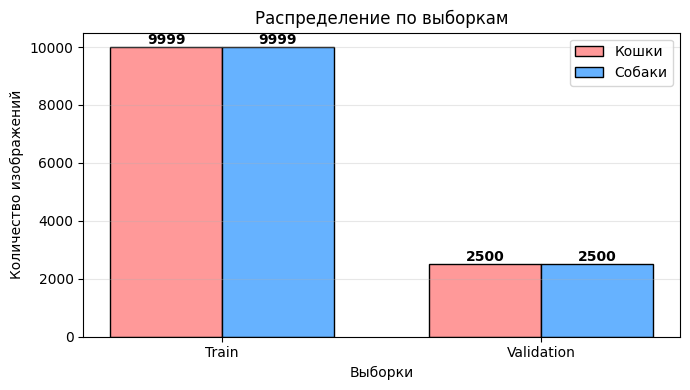

In [616]:
# Данные для визуализации
split_names = ['Train', 'Validation']
cat_counts = [cat_train, cat_val]
dog_counts = [dog_train, dog_val]

fig, axes = plt.subplots(1, figsize=(7, 4))

# 1. Столбчатая диаграмма
x = np.arange(len(split_names))
width = 0.35

axes.bar(x - width/2, cat_counts, width, label='Кошки', color='#FF9999', edgecolor='black')
axes.bar(x + width/2, dog_counts, width, label='Собаки', color='#66B2FF', edgecolor='black')

axes.set_xlabel('Выборки')
axes.set_ylabel('Количество изображений')
axes.set_title('Распределение по выборкам')
axes.set_xticks(x)
axes.set_xticklabels(split_names)
axes.legend()
axes.grid(axis='y', alpha = 0.3)

# Добавляем значения на столбцы
for i in range(len(split_names)):
    axes.text(i - width/2, cat_counts[i] + 10, str(cat_counts[i]),
                ha='center', va='bottom', fontweight='bold')
    axes.text(i + width/2, dog_counts[i] + 10, str(dog_counts[i]),
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Создание генераторов

In [7]:
train_gen = ImageDataGenerator(rescale = 1./255)
validation_gen =  ImageDataGenerator(rescale = 1./255.)

In [ ]:
train_generator = train_gen.flow_from_directory('dataset/train',
                                                target_size = (200, 200),
                                                batch_size  = 64,
                                                class_mode = 'binary'
                                               )

validation_generator = validation_gen.flow_from_directory('dataset/val',
                                                          target_size = (200, 200),
                                                          batch_size  = 64,
                                                          class_mode  = 'binary'
                                                         )

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Модель

### Инициализация

In [ ]:
def CatsDogsCNN(input_shape = (200, 200, 3)):
    '''
    Модель CNN для классификации кошек и собак
    '''

    # Входной слой
    inputs = Input(shape=input_shape)

    # Блок 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    # Блок 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(2, 2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    # Блок 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)

    # Полносвязные слои
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Выходной слой
    outputs = Dense(1, activation = 'sigmoid')(x)

    # Создаем модель
    model = Model(inputs = inputs, outputs = outputs, name = 'CatsDogsCNN')
    model.compile(optimizer        = Adam(learning_rate = 1e-4),
                  loss             = 'binary_crossentropy',
                  metrics          = ['accuracy']
                 )

    return model

### Обучение

In [17]:
import warnings
warnings.filterwarnings('ignore', message = 'Your `PyDataset` class')

In [ ]:
checkpoint = ModelCheckpoint(filepath          = '/content/drive/MyDrive/dataset/cnn_model-2.keras',
                             monitor           = 'val_accuracy',        # Мониторим val accuracy
                             save_best_only    = True,                  # Сохраняем только лучшую модель
                             save_weights_only = False,                 # Сохраняем архитектуру + веса
                             mode              = 'max',                 # Максимизируем метрику (accuracy)
                             verbose           = 1                      # Выводим сообщения о сохранении
                            )
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
reduce         = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 5, verbose = 3, factor = 0.3,
                                   min_lr = 1e-7, mode = 'max')

model = CatsDogsCNN()
history    = model.fit(train_generator,
                       validation_data = validation_generator,
                       epochs = 150,
                       callbacks  = [reduce,
                                     early_stopping,
                                     checkpoint,
                                     CSVLogger('/content/drive/MyDrive/dataset/log-2.csv', separator = ",", append = False)
                                    ],
                       shuffle = True
                      )

Epoch 1/150
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.5775 - loss: 0.8072

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))



Epoch 1: val_accuracy improved from -inf to 0.55160, saving model to /content/drive/MyDrive/dataset/cnn_model-2.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 173s 447ms/step - accuracy: 0.5776 - loss: 0.8071 - val_accuracy: 0.5516 - val_loss: 0.6854 - learning_rate: 1.0000e-04
Epoch 2/150
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6242 - loss: 0.7007
Epoch 2: val_accuracy did not improve from 0.55160
313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 359ms/step - accuracy: 0.6242 - loss: 0.7007 - val_accuracy: 0.5472 - val_loss: 0.8975 - learning_rate: 1.0000e-04
Epoch 3/150
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6644 - loss: 0.6336
Epoch 3: val_accuracy improved from 0.55160 to 0.56320, saving model to /content/drive/MyDrive/dataset/cnn_model-2.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 112s 357ms/step - accuracy: 0.6645 - loss: 0.6336 - val_accuracy: 0.5632 - val_loss: 0.8871 - learning_rate: 1.0000e-04
Epoch 4/150
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.6982 - loss: 0.

In [19]:
model.summary()

Model: "CatsDogsCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 200, 200, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,515,973 (9.60 MB)

 Trainable params: 838,017 (3.20 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 1,676,036 (6.39 MB)

### Анализ обучения

In [21]:
# Оценка модели
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Лучшая точность: {val_acc:.4f}")

39/79 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9396 - loss: 0.1954

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.9413 - loss: 0.1928
Лучшая точность: 0.9432


<Axes: >

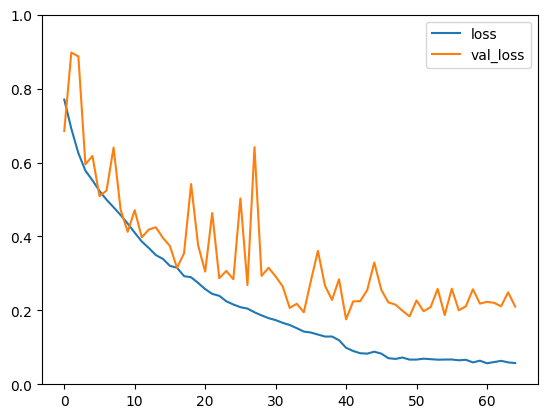

In [22]:
losses = pd.DataFrame(history.history)
losses[['loss','val_loss']].plot(ylim = (0, 1))

<Axes: >

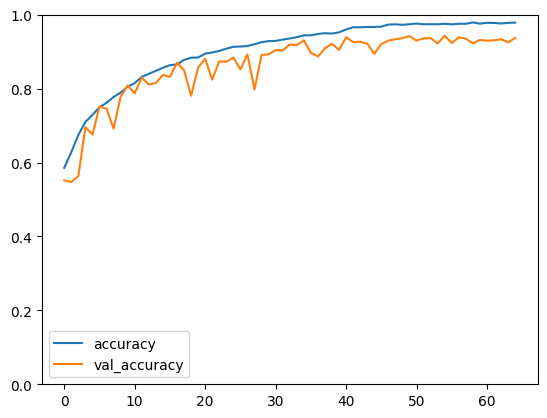

In [23]:
losses[['accuracy','val_accuracy']].plot(ylim = (0, 1))

### Тестирование

In [617]:
test_gen = ImageDataGenerator(rescale = 1./255)

In [935]:
test_generator = test_gen.flow_from_directory('dataset/test-2',
                                              target_size = (200, 200),
                                              batch_size  = 64,
                                              class_mode  = 'binary'
                                             )

Found 55 images belonging to 2 classes.


In [3]:
model = load_model('cnn_model-2.keras')

In [937]:
y_pred = model.predict(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
y_pred = (y_pred > 0.5).astype(int).flatten()
y_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [939]:
y_test = test_generator.classes
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71        30
           1       0.65      0.68      0.67        25

    accuracy                           0.69        55
   macro avg       0.69      0.69      0.69        55
weighted avg       0.69      0.69      0.69        55

